## Visualización de NDVI y EVI

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
import os

import rioxarray 
from rioxarray.merge import merge_datasets
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

Directorio de trabajo

In [2]:
print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

> Directorio actual:  /media/javier/Compartida/doctorado/gee-metview/venezuela/code
> Directorio actual:  /media/javier/Compartida/doctorado/gee-metview


#### Clase para archivos NASA

In [3]:
class NASA_HDF_CARACTERISTICAS:
  """
  clase para la manipulacion de los archivos .hdf de la NASA
  """
  
  #--
  def __init__(self, path):

    from datetime import datetime

    self.path=path
    self.caracter = path.split('/')[-1].split('.')
    self.product = self.caracter[0]
    self.date_time = self.caracter[1]
    self.hori_ver_number = self.caracter[2]
    self.colle_number = self.caracter[3]
    self.product_date_time = self.caracter[4]
    self.hn = self.hori_ver_number.split('v')[0].split('h')[1]
    self.vn = self.hori_ver_number.split('v')[1]
    self.date = datetime.strptime(self.date_time, 'A%Y%j').strftime('%Y-%m-%d')
    self.year = datetime.strptime(self.date_time, 'A%Y%j').strftime('%Y')
    self.product_date = datetime.strptime(self.product_date_time, "%Y%d%m%H%M%S")

  #--
  @classmethod
  def nasa_carat(cls,path):

    try:
      return cls(path)
    
    except:
      return None
      
  #--
  def open_rasterio(self,variable):

    import rioxarray 

    try:
      self.rds = rioxarray.open_rasterio(self.path,
                                         masked=True,
                                         variable=variable).squeeze()
    
    except:
      return None
  
  #--
  @staticmethod
  def create_tif_park_data(rds_list, park_boundary):

    # merge de rds
    # rds = rds_list[0]\
    #         .rds.merge(rds_list[1].rds)\
    #         .merge(rds_list[2].rds)\
    #         .squeeze()
    rds = merge_datasets( list(map(lambda x: x.rds, rds_list)) )


    # validando crs
    if not park_boundary.crs == rds.rio.crs:
        park_bound_sin = park_boundary.to_crs(rds.rio.crs)

    # ndvi del parque
    ndvi = rds.rio.clip(park_bound_sin.geometry.apply(mapping),
                        all_touched=True,
                        from_disk=True)\
                        .squeeze()\
                        .chunk("auto")

    return ndvi


In [4]:
path = './MOD13Q1/2022/049'
files = list(map( lambda x: path + '/' + x, os.listdir(path) ))
files

['./MOD13Q1/2022/049/MOD13Q1.A2022049.h10v08.006.2022066002309.hdf',
 './MOD13Q1/2022/049/MOD13Q1.A2022049.h11v07.006.2022066000908.hdf',
 './MOD13Q1/2022/049/MOD13Q1.A2022049.h11v08.006.2022066002558.hdf']

In [5]:
nasa_files = list(filter(lambda x: x!=None ,list(map(lambda x: NASA_HDF_CARACTERISTICAS.nasa_carat(x), files)) )) 

In [6]:
nasa_files[0].date

'2022-02-18'

In [7]:
# open_rasterio
def open_rds(x):
  variable = ['250m 16 days NDVI','250m 16 days EVI']
  x.open_rasterio(variable=variable)
  return x

rds_list = list(map(
                lambda x: open_rds(x),
                nasa_files
              ))

In [8]:
rds_list[0].rds.rio.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [9]:
vegetacion_rds = merge_datasets( list(map(lambda x: x.rds, rds_list)) )
scale_factor = 0.0001 
vegetacion_rds['NDVI'] = (scale_factor * vegetacion_rds['250m 16 days NDVI'])
vegetacion_rds['EVI'] = (scale_factor * vegetacion_rds['250m 16 days EVI'])

In [10]:
vegetacion_rds

<xarray.Dataset>
Dimensions:            (y: 9601, x: 9601)
Coordinates:
    band               int64 1
  * x                  (x) float64 -8.895e+06 -8.895e+06 ... -6.672e+06
  * y                  (y) float64 2.224e+06 2.224e+06 ... 115.8 -115.8
    spatial_ref        int64 0
Data variables:
    250m 16 days NDVI  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    250m 16 days EVI   (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDVI               (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    EVI                (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0.0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

In [11]:
vegetacion_rds.to_netcdf('./venezuela/ndvi/vegetacion_for_plot.nc')

### Gráfico del NDVI y EVI producto MOD13Q1

In [12]:
import os

import rioxarray 
from rioxarray.merge import merge_datasets
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
vegetacion_rds = rioxarray.open_rasterio('./venezuela/ndvi/vegetacion_for_plot.nc',
                              masked=True,
                              variable = ['NDVI','EVI']
                              )\
                              .squeeze()
# proyeccion
vegetacion_rds

<xarray.Dataset>
Dimensions:      (y: 9601, x: 9601)
Coordinates:
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 9.598e+03 9.6e+03 9.6e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 9.598e+03 9.6e+03 9.6e+03
    band         int64 1
    spatial_ref  int64 0
Data variables:
    NDVI         (y, x) float32 ...
    EVI          (y, x) float32 ...
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

#### Gráfico del NDVI

In [15]:
# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = vegetacion_rds.NDVI.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('NDVI',fontsize=18)
ax.add_collection(graf)


# titulos
date_srt = '2022-02-18'
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Producto MOD13Q1 NDVI\nDía: {date_srt}",ha='left',fontsize=30,x=0.125)
plt.xlabel("x",loc='center',fontsize=18)
plt.ylabel("y",loc='center',fontsize=18)

plt.savefig('./venezuela/figures/nasa_ndvi.png')

#plt.show()

: 

: 

#### Gráfico del EVI

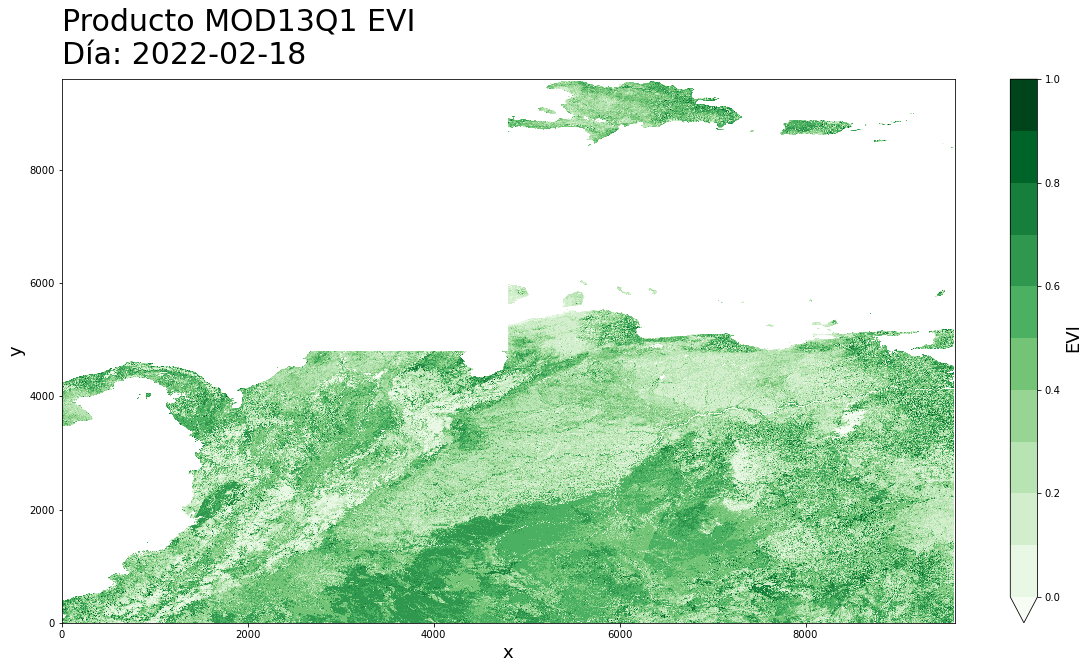

In [ ]:
# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
graf = vegetacion_rds.EVI.plot(cmap='Greens',levels=levels)
graf.colorbar.set_label('EVI',fontsize=18)
ax.add_collection(graf)


# titulos
date_srt = '2022-02-18'
plt.title(f"",fontsize=30,loc='center')
plt.suptitle(f"Producto MOD13Q1 EVI\nDía: {date_srt}",ha='left',fontsize=30,x=0.125)
plt.xlabel("x",loc='center',fontsize=18)
plt.ylabel("y",loc='center',fontsize=18)

plt.savefig('./venezuela/figures/nasa_evi.png')

#plt.show()